# KnapsackV2 - Group 3
1BM120

In [137]:
import numpy as np
import gym
import or_gym
import random
from math import sqrt
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.plotting import scatterplotmatrix
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Part 1: Explore Knapsack

 **Task 1:** 
- Create an instance of the environment
- Print and plot the state and action space

In [138]:
env = or_gym.make("Knapsack-v2") # Create an  instance of the environment 
env.mask = False

In [143]:
state = env.reset()
action_space = env.action_space.n
print('Action space', action_space, "\n")
for item in range(env.N):
    print("Item: {} \t ratio: {} \t reward: {} \t weight: {} \t limit: {}".format(item, round(state[1][item] / state[0][item],2), state[1][item], state[0][item], state[2][item]))

Action space 200 

Item: 0 	 ratio: 8.86 	 reward: 62 	 weight: 7 	 limit: 4
Item: 1 	 ratio: 1.78 	 reward: 71 	 weight: 40 	 limit: 2
Item: 2 	 ratio: 0.14 	 reward: 8 	 weight: 58 	 limit: 3
Item: 3 	 ratio: 1.37 	 reward: 81 	 weight: 59 	 limit: 9
Item: 4 	 ratio: 0.54 	 reward: 19 	 weight: 35 	 limit: 6
Item: 5 	 ratio: 4.64 	 reward: 65 	 weight: 14 	 limit: 2
Item: 6 	 ratio: 2.93 	 reward: 85 	 weight: 29 	 limit: 4
Item: 7 	 ratio: 1.0 	 reward: 72 	 weight: 72 	 limit: 6
Item: 8 	 ratio: 0.53 	 reward: 47 	 weight: 89 	 limit: 8
Item: 9 	 ratio: 0.16 	 reward: 14 	 weight: 89 	 limit: 1
Item: 10 	 ratio: 1.39 	 reward: 86 	 weight: 62 	 limit: 1
Item: 11 	 ratio: 0.26 	 reward: 9 	 weight: 34 	 limit: 7
Item: 12 	 ratio: 13.0 	 reward: 91 	 weight: 7 	 limit: 7
Item: 13 	 ratio: 1.39 	 reward: 78 	 weight: 56 	 limit: 9
Item: 14 	 ratio: 0.9 	 reward: 38 	 weight: 42 	 limit: 9
Item: 15 	 ratio: 1.26 	 reward: 88 	 weight: 70 	 limit: 1
Item: 16 	 ratio: 0.66 	 reward: 64 	

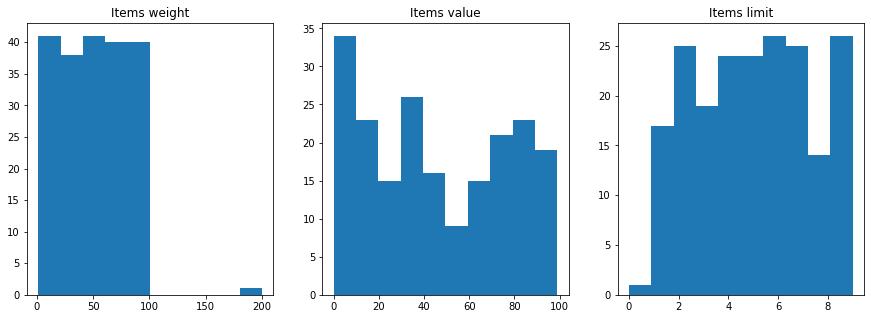

In [141]:
# Plot of the state space

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))

ax1.hist(state_space[0])
ax1.set_title("Items weight")

ax2.hist(state_space[1])
ax2.set_title("Items value")

ax3.hist(state_space[2])
ax3.set_title("Items limit")

plt.show()

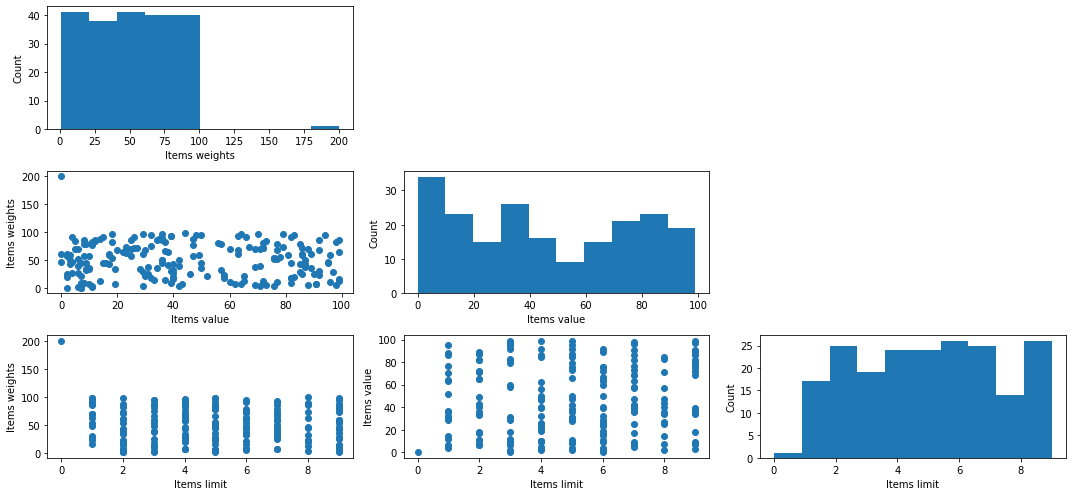

In [142]:
X = np.array([state_space[0], state_space[1], state_space[2]]).T
scatterplotmatrix(X, figsize=(15, 7), names = ["Items weights", "Items value", "Items limit"])
plt.tight_layout()
plt.show()

**Task 2:**
- Sample an action from the environment.
- Call the step function and inspect the outputs.

**Task 3:**
- Randomly interact with the envrionment for two episodes.  

In [147]:
for episode in range(2):
    state = env.reset()# get the starting state from the env.
    total_reward = 0; weight = 0; nr_items = 0
    done = False
    print("\nEPISODE ", episode)
    print("__________")
    for step in range(99): 
        action = env.action_space.sample() # is the index of the items list
        new_state, reward, done, info = env.step(action) #give the action to environment to obtain reward, and next state, 
        #print(new_state)
        p = env.observation_space["avail_actions"]
        print("Item {} with a reward of {}".format(action, reward))
        if done: # if the goal state is reached or bag is full. 
            print("\nItem {} exceeded the limit which has a weight of {}".format(action, new_state[0][action])) # Chosen a item that exceeds the capacity
            print("Total weight sack =\t", env.current_weight)
            print("Number of items =\t", nr_items)
            print("Total reward =\t", total_reward)         
            
            break
        nr_items += 1
        total_reward += reward
        state = new_state
        weight = state[0][action]
env.close()


EPISODE  0
__________
Item 54 with a reward of 26
Item 20 with a reward of 96
Item 48 with a reward of 69
Item 84 with a reward of 31
Item 74 with a reward of 0

Item 74 exceeded the limit which has a weight of 94
Total weight sack =	 176
Number of items =	 4
Total reward =	 222

EPISODE  1
__________
Item 79 with a reward of 6
Item 106 with a reward of 4
Item 74 with a reward of 63
Item 97 with a reward of 0

Item 97 exceeded the limit which has a weight of 45
Total weight sack =	 182
Number of items =	 3
Total reward =	 73


### Neural network

## Model training 🧠

Parameters:

In [ ]:
TRAIN_EPSISODES = 10_000
TEST_EPSISODES = 100
LEARNING_RATE = 0.4 
DISCOUNT_RATE = 0.9 
MIN_REPLAY_SIZE = 250
BATCH_SIZE = 100 # Number of items to be sampled
FACTOR = 2 # How much one wants to punish or prize high rewards
HIGH_PER = 10 # The high and low percentage of rewards in the replay memory
MAX_EPSILON = 1 # You can't explore more than 100% of the time
MIN_EPSILON = 0.01 # At a minimum, we'll always explore 1% of the time
DECAY = 0.0005 # How fast the epsilon decays

Import model and functions

In [130]:
def line_plot(data, title = "", subtitle = "", ylabel = "", file_name = "output", line_thick = 1):
    """
    LINEPLOTTER
    
    data: must be of type list, multilist or dictionary
    title: Title on the top of the figure (type = str)
    subtitle: Extra title (type = str)
    ylabel: Name of the ylabel (type = str)
    file_name: name of the file, saved in your current directory (type = str)
    line_thick: thickness of the lines
    """
    plt.figure(figsize=(15, 7)) # Figure size
    other_font = {'fontname': 'arial'} # Font type

    if isinstance(data, list):
        if isinstance(data[0], list): # Multilist
            i = 1
            for output in data:
                plt.plot(range(len(output)), output, linewidth = line_thick, label = "Scenario " + str(i))
                i += 1
        else: # List
            plt.plot(range(len(data)), data, linewidth = line_thick)
    
    elif isinstance(data, dict):
        for output, label in zip(list(data.values()), list(data.keys())):
            plt.plot(range(len(output)), output, linewidth = line_thick, label = label)
    else:
        print("{} are not allowed, only lists, multilists and dictionaries are allowed".format(type(data)))
    
    # Styling
    plt.ylabel(ylabel, fontsize = 16, ** other_font)
    plt.xlabel("Episodes", fontsize = 16, ** other_font)
    plt.title(title, loc='left', fontsize=20, fontweight = "bold", ** other_font)
    plt.title(subtitle, loc='right', fontsize=14, color='dimgray', ** other_font)
    plt.legend(loc = 1, edgecolor = 'white')
    plt.savefig(file_name + ".jpg")
    plt.show()

In [145]:
item_count = env.N
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(item_count * 3, activation="relu", input_shape=(item_count,)))
model.add(Dense(item_count * 2, activation="relu"))
model.add(Dense(item_count, activation="relu"))

## Part 2: Q-Table 🗄️
We will implement Q-learning algorithm to devise optimal policy for FrozenLake environment. 

In [ ]:
def epsilon_greedy_policy(Q, state, epsilon): 
      # Q:          : state-action pair
      # State (int) : current state
      # eps (float): epsilon
    action = 0
    if random.uniform(0, 1) > epsilon: #exploitation
        action = np.argmax(Q[state,:])
    else: #exploration 
        action = env.action_space.sample()
    return action


The algorithm takes nine arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `total_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `max_step`: This is the max number of interactions between agent and env. within a single episode.  
- `epsilon`: This is to encourage exploration. Epsilon is decayed over time to discourage explortation and encourage exploitation once agent has explored different state. 
- `max_epsilon`: This is the maximum value of epsilon. 
- `min_epsilon`: This is the minimum value of epsilon. 
- `decay_rate`: This is the decay rate for epsilon. 
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `plot_every`: This is additional argument to plot the cumulative reward against episodes. 

The algorithm returns as output:
- `qtable`: This is an ndarray where `qtable[s][a]` is the estimated action value corresponding to state `s` and action `a`.

**Task 5**
- Fill the missing code to complete the Q-learning implementation.
- Write a condition to break the loop as soon as agent receives a reward of 0.78 or higher in 100 consecutive episodes.

In [ ]:
def q_learning(env, total_episodes, max_steps = 99, epsilon = 1.0, max_epsilon = 1.0, min_epsilon = 0.01, decay_rate = 0.005,  gamma=0.95, plot_every=100):
    rewards = []   # List of rewards
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=total_episodes)   # average scores over every plot_every episodes
    for episode in range(total_episodes):
        state = env.reset()#Reset the environment to the starting state 
        #step = 0 
        done = False
        total_rewards = 0 # collected reward within an episode
        if episode % 100 == 0: #monitor progress
            print("\rEpisode {}/{}".format(episode, total_episodes), end="") 
        
        for step in range(max_steps): 
            action = epsilon_greedy_policy(qtable, state, epsilon)# call the epsilon greedy policy to obtain the actions  
            new_state, reward, done, info = env.step(action) #take the action and observe resulting reward and state. 

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action]) #update the qtable. np.max(qtable[new_state, :] is greedy action used for learning!. 

            total_rewards += reward # sum the rewards collected within an episode
            state = new_state # Our new state is state
            if done == True: #done is true when agent fall into hole or reached the goal state
                tmp_scores.append(total_rewards)  #for plot
                break
        if (episode % plot_every == 0): #for plot
            avg_scores.append(np.mean(tmp_scores))
            
            #....  #break the loop as soon as agent obtain the reward of 0.78 or higher in 100 consective episodes. 
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) # Reduce epsilon value to encourage expoitation and discouage exlortation 
        rewards.append(total_rewards)

    # plot performance
    plt.plot(np.linspace(0,total_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    return qtable



## Part 4: Train the agent  🤖
Here comes the real part. 
- We will train our agent using Q-learning algorithm defined above.   

**Task 6**
- Call the Q-learning algorithm with appropriate hyperparameter setting. 
- Find the hyper-parameters configuration  to solve the environment in fewer than 5000 training episodes. 

In [ ]:
total_episodes = 20000       # Total episodes
learning_rate = 0.2#7          # Learning rate
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

In [ ]:
q_learning(env, total_episodes, epsilon = 1.0, gamma=0.95, plot_every=100)

## Part 5: Action in Action! 🕹️
- After training, the agent has develop a Q-table can be used to play FrozenLake. The Q-table tells agent which action to take in each state. 
- Run the code below to see our agent playing FrozenLake.

In [ ]:
env.reset()

for episode in range(5):
    state = env.reset()
    step = 0
    done = False
    print("********************")
    print("EPISODE ", episode)
    for step in range(max_steps):
        action = np.argmax(qtable[state,:])# Take the action (index) with maximum expected future reward given that state
        new_state, reward, done, info = env.step(action)
        if done:
            env.render()
            if new_state == 15:
                print("Goal 🏅")
            else:
                print("Hole 💀")            
            # We print the number of step it took.
            print("Number of steps", step)            
            break
        state = new_state
env.close()